# Final NLP Model
This notebook contains the final nlp model for Kenya's loans. The independent variable (X) includes combined text from the Description_Translated, Loan_Use and Tags columns. Also, the Tags column was separated by tags not by individual words. For preprocessing, regular expressions and lemmatizing was used along with the removal of English stopwords. The dependent variable (y) is the status column where 0=expired and 1=funded. For modeling, logistic regression was used alongside a Tf-IDF Vectorizer with 1-2 ngrams and 10,000 max features.

### Importing Libraries and Loading Data

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
kiva = pd.read_csv('/Users/precious/dsi/Group-Project/kenya_joined_tags_full_text.csv')

In [38]:
kiva.head(2)

,LOAN_ID,COUNTRY_NAME,STATUS,DESCRIPTION_TRANSLATED,LOAN_USE,TAGS,processed_TAGS,all_text,joined_text
0,1799331,Kenya,1,Dinnah is 43 years of age and a proud mother o...,to buy farm inputs such as seeds and fertilize...,#Parent,#Parent,"['dinnah', '43', 'year', 'age', 'proud', 'moth...",dinnah 43 year age proud mother 5 4 school goi...
1,1294719,Kenya,1,Resy is a married woman and has been blessed w...,to purchase chicks and poultry feed.,"#Animals, #Woman-Owned Business, volunteer_pic...","#Animals,#WomanOwnedBusiness,volunteer_pick,#P...","['resy', 'married', 'woman', 'ha', 'blessed', ...",resy married woman ha blessed three kid attend...


In [3]:
kiva.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51019 entries, 0 to 51018
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   LOAN_ID                 51019 non-null  int64 
 1   COUNTRY_NAME            51019 non-null  object
 2   STATUS                  51019 non-null  int64 
 3   DESCRIPTION_TRANSLATED  51019 non-null  object
 4   LOAN_USE                51019 non-null  object
 5   TAGS                    51019 non-null  object
 6   processed_TAGS          43157 non-null  object
 7   all_text                51019 non-null  object
 8   joined_text             51019 non-null  object
dtypes: int64(2), object(7)
memory usage: 3.5+ MB


### Defining Variables & Splitting Train and Test

In [6]:
X = kiva['joined_text']
y = kiva['STATUS']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [8]:
y.value_counts(normalize=False)

1    40001
0    11018
Name: STATUS, dtype: int64

### Final NLP Model: Tf-IDF Vectorizer w/Logistic Regression

In [22]:
tvec = TfidfVectorizer(ngram_range=(1,2), max_features=10_000)
X_train_tvec = tvec.fit_transform(X_train)
X_test_tvec = tvec.transform(X_test)

In [23]:
X_train_tvec.shape

(38264, 10000)

In [24]:
# instantiating and fitting logistic regression model w/default parameters and 1000 max iterations
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_tvec, y_train)

LogisticRegression(max_iter=1000)

### Preparing Model for Streamlit

In [50]:
#function to process input from user
def preprocess_nlp(description, tags):
    processed_tags = tags.replace(' ', '')
    processed_tags = processed_tags.replace('-', '')
    all_text = description + processed_tags
    tokenizer = RegexpTokenizer('\w+|\$[\d.]+|S+')
    token = tokenizer.tokenize(all_text.lower())
    lemmatizer = WordNetLemmatizer()
    lem_token = [lemmatizer.lemmatize(word) for word in token]
    joined_text = ' '.join(lem_token)
    return joined_text

In [70]:
# testing function for use w/model pipeline
input_text = preprocess_nlp('single mom of 3 requesting kes 20,000 for farming equipment', '#parent, #womanownedbusiness')

In [39]:
# creating pipeline for model
nlp_pipe = Pipeline([('tvec', TfidfVectorizer(ngram_range=(1,2), 
                                          max_features=10_000, 
                                          stop_words={'english'})), 
                ('logreg', LogisticRegression(max_iter=1000, random_state=42))])

In [43]:
# fitting pipeline
nlp_pipe.fit(X_train, y_train)

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_features=10000, ngram_range=(1, 2),
                                 stop_words={'english'})),
                ('logreg', LogisticRegression(max_iter=1000, random_state=42))])

In [44]:
# scoring pipeline to make sure scores still accurate
nlp_pipe.score(X_train, y_train), nlp_pipe.score(X_test, y_test)

(0.8374189839013172, 0.8211681693453547)

In [71]:
# testing model on function output and it's performing well
nlp_pipe.predict([input_text])

array([1])

In [63]:
# loading model to pickle for usage in streamlit
pickle.dump(nlp_pipe, open('../nlp_model.p', 'wb'))

In [64]:
# loading model back in to test
nlp_model = pickle.load(open('../nlp_model.p', 'rb'))

In [65]:
# all steps saved in pickled model
nlp_model.named_steps

{'tvec': TfidfVectorizer(max_features=10000, ngram_range=(1, 2), stop_words={'english'}),
 'logreg': LogisticRegression(max_iter=1000, random_state=42)}

In [66]:
# testing negative predictions
nlp_model.predict(['married man parent of 8 requesting kes 100,000 to shop'])

array([0])

In [67]:
# testing positive predictions
nlp_model.predict(['single mom of 3 requesting kes 20,000 for farming equipment'])

array([1])

### Evaluating Model

In [25]:
# scoring logistic regression (ngram1,2, max_feat10_000)
print(f'Train score: {logreg.score(X_train_tvec, y_train)}')
print(f'Test score: {logreg.score(X_test_tvec, y_test)}')

Train score: 0.8373928496759356
Test score: 0.8214817718541748


In [26]:
# creating predictions from test data
logreg_preds = logreg.predict(X_test_tvec)

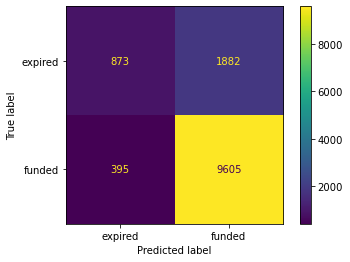

In [36]:
# showing predictions vs true status where 0=expired and 1=funded
logreg_cm = confusion_matrix(y_test, logreg_preds)
ConfusionMatrixDisplay(logreg_cm, display_labels = ['expired', 'funded']).plot();

In [28]:
print(f'ROC AUC: {roc_auc_score(y_test, logreg_preds)}')
print(f'Cross Val Score: {cross_val_score(logreg, X_train_tvec, y_train, cv=3).mean()}')

ROC AUC: 0.6386892014519057
Cross Val Score: 0.8163809445126128


In [29]:
print(classification_report(y_test, logreg_preds))

              precision    recall  f1-score   support

           0       0.69      0.32      0.43      2755
           1       0.84      0.96      0.89     10000

    accuracy                           0.82     12755
   macro avg       0.76      0.64      0.66     12755
weighted avg       0.80      0.82      0.79     12755



In [33]:
# creating dataframe of coefs
word_coef_df = pd.DataFrame({'coefs': logreg.coef_[0], 'word_combinations': tvec.get_feature_names()})

In [34]:
# top 15 word combinations and their coefficients
word_coef_df.nlargest(15, 'coefs')

,coefs,word_combinations
63,5.614132,20 000
125,3.470010,30 000
5237,3.381368,kes 20
8565,3.338394,singleparent
62,3.326476,20
9441,3.211537,user_favorite
8558,3.091468,single mother
9743,2.488434,widowed
47,2.448559,15 000
5230,2.440288,kes 000


In [35]:
# lowest 15 word combinations and their coefficients
word_coef_df.nsmallest(15, 'coefs')

,coefs,word_combinations
27,-4.320953,100 000
26,-4.180876,100
6045,-3.664855,man
7910,-3.484908,repeatborrower
7893,-3.371616,repairrenewreplace
954,-3.265535,bizdurableasset
6921,-3.145058,parent
52,-2.864306,150 000
51,-2.810579,150
38,-2.748698,120 000


In [ ]:
#create a dictionary with the probability that a loan will be funded
predict_proba_dict = {'probability (success)' : logreg.predict_proba(X_test_tvec)[:,1],
                     'prediction' : logreg.predict(X_test_tvec),
                     'actual' : y_test,
                     'post_text' : X_test}